In [ ]:
# !pip install -r ../requirements.txt

In [ ]:
import os
import re

import json
import numpy as np
from typing import Tuple

import matplotlib.pyplot as plt
from langchain.llms import OpenAI

from langchain_experimental.tot.base import ToTChain
from langchain_experimental.tot.checker import ToTChecker
from langchain_experimental.tot.thought import ThoughtValidity

##Load API key ------------------
f = open('../apikeys/api.txt', 'r')
key = f.readline()
os.environ['OPENAI_API_KEY'] = key

In [ ]:
class MyChecker(ToTChecker):
    def evaluate(self,
        problem_description: str,
        thoughts: Tuple[str, ...] = ()) -> ThoughtValidity:
        
        last_thought = thoughts[-1]
        clean_solution = last_thought.replace(" ", "").replace('"', "")
        regex_solution = clean_solution.replace("*", ".").replace("|", "\\|")
        if sudoku_solution in clean_solution:
            return ThoughtValidity.VALID_FINAL
        elif re.search(regex_solution, sudoku_solution):
            return ThoughtValidity.VALID_INTERMEDIATE
        else:
            return ThoughtValidity.INVALID


In [ ]:
difficulty_map = {'base':2,
                    'easy': 2,
                    'medium': 2,
                    'hard': 3,
                    'expert':4}

In [ ]:
# data_config = {}
datadir = '../src/data/'
models = ["text-davinci-003"]
data_config = {}
for model in models:
    llm = OpenAI(temperature=0.1, max_tokens=512, model=model)
    data_config[model] = {}
    for file in os.listdir(datadir):

        tile_size = file.split('.')[0].split('_')[-1]
        grid = tile_size.split('x')[0]
        subgrid = str(int(np.sqrt(int(grid))))+'x'+str(int(np.sqrt(int(grid))))
        children_thoughts = difficulty_map[file.split('_')[0]]*int(grid)
        
        with open(datadir+file) as f:
            data = f.read()

        data = json.loads(data)

        sudoku_puzzle = data['sudoku_puzzle']
        sudoku_solution = data['sudoku_solution']

        problem_description = f"""
            {sudoku_puzzle}

            - This is a {tile_size} Sudoku puzzle.
            - The * represents a cell to be filled.
            - The | character separates rows.
            - At each step, replace one or more * with digits 1-{grid}.
            - There must be no duplicate digits in any row, column or {subgrid} subgrid.
            - Keep the known digits from previous valid thoughts in place.
            - Each thought can be a partial or the final solution.
            """.strip()


        temp_dict = {'grid_size':tile_size,
                    'children_thoughts':children_thoughts,
                    'problem_description': problem_description,
                    'initial_sudoku': sudoku_puzzle,
                    'sudoku_solution': sudoku_solution,
                    'children': children_thoughts,
                    }

        checker = MyChecker()

        for ii in range(1, 21):
            k = ii*5
            tot_chain = ToTChain(llm=llm,
                                checker=MyChecker(),
                                k=k,
                                c=children_thoughts,
                                verbose=False,
                                verbose_llm=False)
                                
            solution = tot_chain.run(problem_description=problem_description)
            if solution == sudoku_solution:
                break
        
        temp_dict['final_solution'] = solution
        temp_dict['k'] = k
        data_config[file] = temp_dict


In [7]:
datadir = '../src/artifacts/'
savefile = 'text-davinci-003'+'_difficulty_eda_4x4.json'
file_path = datadir+savefile
# Writing the dictionary to a JSON file in append mode
with open(file_path, "a") as json_file:
    json.dump(data, json_file)

In [55]:
c = 0
counter = []
ks = []
difficulty_dict = {
                    'easy': {'ks': [], 'counter': 0},
                    'medium': {'ks': [], 'counter': 0},
                    'hard':  {'ks': [], 'counter': 0}}
for i in data_config.keys():
    for j in difficulty_dict.keys():
        if j in i:
            difficulty_dict[j]['ks'].append(data_config[i]['k'])
            difficulty_dict[j]['counter'] += 1
    c += 1
    counter.append(c)
    ks.append(data_config[i]['k'])

In [64]:
data_config.keys()

dict_keys(['medium_3_base_problem_4x4.txt', 'base_problem_4x4.txt', 'easy_base_problem_4x4.txt', 'medium_2_base_problem_4x4.txt', 'hard_1_base_problem_4x4.txt', 'hard_2_base_problem_4x4.txt', 'medium_4_base_problem_4x4.txt', 'medium_base_problem_4x4.txt', 'hard_base_problem_4x4.txt', 'hard_3_base_problem_4x4.txt', 'medium_5_base_problem_4x4.txt'])

In [83]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

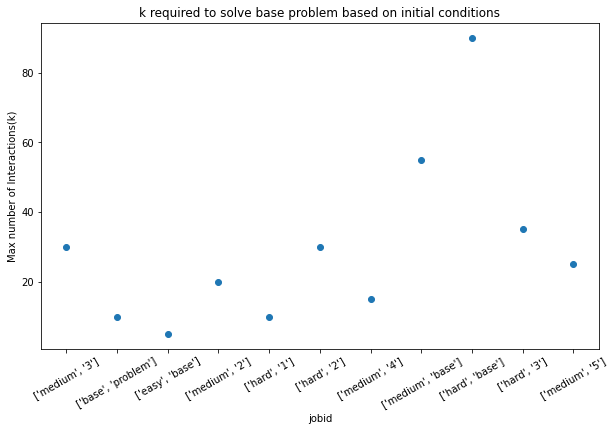

In [91]:
plt.figure(figsize=(10,6))  
ax = plt.axes()
# depict illustration
plt.scatter([i for i in range(11)], ks)
plt.xlabel('jobid')  
plt.ylabel('Max number of Interactions(k)')
plt.title("k required to solve base problem based on initial conditions")
# setting ticks for x-axis
  
# setting label for x tick
ax.set_xticks([i for i in range(11)])
ax.set_xticklabels([i.split('.')[0].split('_')[0:2] for i in data_config.keys()], rotation = 30)
plt.savefig(datadir+'max_k.jpg')

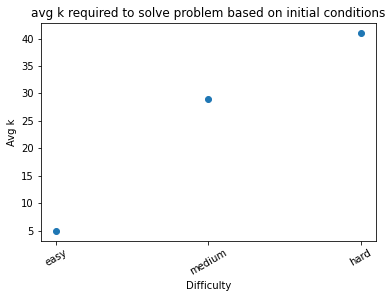

In [90]:
ax = plt.axes()
  
# depict illustration
plt.scatter([i for i in range(3)], [int(np.round(sum(difficulty_dict[key]['ks'])/difficulty_dict[key]['counter'],0)) for key in difficulty_dict.keys()])
plt.xlabel('Difficulty')  
plt.ylabel('Avg k')
plt.title("avg k required to solve problem based on initial conditions")

# setting label for x tick
ax.set_xticks([i for i in range(3)])
ax.set_xticklabels([i for i in difficulty_dict.keys()], rotation = 30)
plt.savefig(datadir+'avg_k.jpg')